This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/tree/main/wallaroo-testing-tutorials/anomaly_detection).

## House Price Testing Saga

This tutorial simulates using Wallaroo assays to detect model or data drift, and Wallaroo Shadow Deploy to compare different models to determine which one is most fit for an organization's needs.  These two features allow organizations to monitor model performance and accuracy, then swap them out as needed.

* **IMPORTANT NOTE**: This tutorial assumes that historical data is available for the assays functionality.  The code for creating and using assays has been commented out, but is made available for examination and as examples.

This tutorial will demonstrate how to:

1. Select or create a workspace, pipeline and upload the champion model.
1. Add a pipeline step with the champion model, then deploy the pipeline and perform sample inferences.
1. Create an assay baseline and display 
1. Establish a pipeline and add the model as a step.
1. Create an assay with baseline data and display anomalies.
1. Swap out the pipeline step with the champion model with a shadow deploy step that compares the champion model against two competitors.
1. Evaluate the results of the champion versus competitor models.
1. Swap out the shadow deploy pipeline step with the new challenger model.
1. Undeploy the pipeline.

This tutorial provides the following:

* Models:
  * `models/rf_model.onnx`: The champion model that has been used in this environment for some time.
  * `models/xgb_model.onnx` and `models/gbr_model.onnx`: Rival models that will be tested against the champion.
* Data:
  * `data/xtest-1.df.json` and `data/xtest-1k.df.json`:  DataFrame JSON inference inputs with 1 input and 1,000 inputs.
  * `data/xtest-1k.arrow`:  Apache Arrow inference inputs with 1 input and 1,000 inputs.

## Prerequisites

* A deployed Wallaroo instance
* The following Python libraries installed:
  * [`wallaroo`](https://pypi.org/project/wallaroo/): The Wallaroo SDK. Included with the Wallaroo JupyterHub service by default.
  * [`pandas`](https://pypi.org/project/pandas/): Pandas, mainly used for Pandas DataFrame
  * [`polars`](https://pypi.org/project/polars/): Polars for DataFrame with native Apache Arrow support

## Steps

### Import libraries

The first step is to import the libraries needed for this notebook.

In [128]:
import wallaroo
from wallaroo.object import EntityNotFoundError

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

import os
# For Wallaroo SDK 2023.1
os.environ["ARROW_ENABLED"]="True"

import datetime

### Connect to Wallaroo Instance

The following command will create a connection to the Wallaroo instance and store it in the variable `wl`.

In [129]:
# Login through local Wallaroo instance

# wl = wallaroo.Client()

# SSO login through keycloak

wallarooPrefix = "YOUR PREFIX"
wallarooSuffix = "YOUR PREFIX"

wallarooPrefix = "doc-test"
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}.api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}.keycloak.{wallarooSuffix}", 
                    auth_type="sso")

### Create Workspace

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

In [130]:
workspace_name = 'housepricesagaworkspace'
main_pipeline_name = 'housepricesagapipeline'
model_name_control = 'housepricesagacontrol'
model_file_name_control = './models/rf_model.onnx'

In [131]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

In [132]:
workspace = get_workspace(workspace_name)

wl.set_current_workspace(workspace)

{'name': 'houseprice', 'id': 12, 'archived': False, 'created_by': 'ce15ed10-9217-48fb-a9bf-ecbff480a87a', 'created_at': '2023-04-04T18:12:23.229104+00:00', 'models': [{'name': 'housingcontrol', 'versions': 3, 'owner_id': '""', 'last_update_time': datetime.datetime(2023, 4, 5, 21, 8, 8, 504421, tzinfo=tzutc()), 'created_at': datetime.datetime(2023, 4, 4, 18, 12, 25, 889308, tzinfo=tzutc())}, {'name': 'housingchallenger01', 'versions': 2, 'owner_id': '""', 'last_update_time': datetime.datetime(2023, 4, 5, 21, 8, 14, 673381, tzinfo=tzutc()), 'created_at': datetime.datetime(2023, 4, 5, 20, 44, 28, 390777, tzinfo=tzutc())}, {'name': 'housingchallenger02', 'versions': 2, 'owner_id': '""', 'last_update_time': datetime.datetime(2023, 4, 5, 21, 8, 15, 952061, tzinfo=tzutc()), 'created_at': datetime.datetime(2023, 4, 5, 20, 44, 29, 692547, tzinfo=tzutc())}], 'pipelines': [{'name': 'housepricepipeline', 'create_time': datetime.datetime(2023, 4, 4, 18, 12, 27, 91404, tzinfo=tzutc()), 'definition':

## Upload The Champion Model

For our example, we will upload the champion model that has been trained to derive house prices from a variety of inputs.  The model file is `rf_model.onnx`, and is uploaded with the name `housingcontrol`.

In [133]:
housing_model_control = wl.upload_model(model_name_control, model_file_name_control).configure()

### Build the Pipeline

This pipeline is made to be an example of an existing situation where a model is deployed and being used for inferences in a production environment.  We'll call it `housepricepipeline`, set `housingcontrol` as a pipeline step, then run a few sample inferences.

In [134]:
mainpipeline = wl.build_pipeline(main_pipeline_name).add_model_step(housing_model_control).deploy()

### Testing

We'll use two inferences as a quick sample test - one that has a house that should be determined around $700k, the other with a house determined to be around $1.5 million.  We'll also save the start and end periods for these events to for later log functionality.

In [135]:
control_model_start = datetime.datetime.now()

normal_input = pd.DataFrame.from_records({"tensor": [[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]]})
result = mainpipeline.infer(normal_input)
display(result)

,time,in.tensor,out.variable,check_failures
0,2023-04-05 21:11:32.811,"[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]",[718013.7],0


In [136]:
large_house_input = pd.DataFrame.from_records({'tensor': [[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]]})
large_house_result = mainpipeline.infer(large_house_input)
display(large_house_result)

,time,in.tensor,out.variable,check_failures
0,2023-04-05 21:11:33.217,"[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]",[1514079.4],0


As one last sample, we'll run through roughly 1,000 inferences at once and show a few of the results.  For this example we'll use an Apache Arrow table, which has a smaller file size compared to uploading a pandas DataFrame JSON file.  The inference result is returned as an arrow table, which we'll convert into a pandas DataFrame to display the first 20 results.

In [137]:
batch_inferences = mainpipeline.infer_from_file('./data/xtest-1k.arrow')

large_inference_result =  batch_inferences.to_pandas()
display(large_inference_result.head(20))

,time,in.tensor,out.variable,check_failures
0,2023-04-05 21:11:33.812,"[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]",[718013.75],0
1,2023-04-05 21:11:33.812,"[2.0, 2.5, 2170.0, 6361.0, 1.0, 0.0, 2.0, 3.0, 8.0, 2170.0, 0.0, 47.7109, -122.017, 2310.0, 7419.0, 6.0, 0.0, 0.0]",[615094.56],0
2,2023-04-05 21:11:33.812,"[3.0, 2.5, 1300.0, 812.0, 2.0, 0.0, 0.0, 3.0, 8.0, 880.0, 420.0, 47.5893, -122.317, 1300.0, 824.0, 6.0, 0.0, 0.0]",[448627.72],0
3,2023-04-05 21:11:33.812,"[4.0, 2.5, 2500.0, 8540.0, 2.0, 0.0, 0.0, 3.0, 9.0, 2500.0, 0.0, 47.5759, -121.994, 2560.0, 8475.0, 24.0, 0.0, 0.0]",[758714.2],0
4,2023-04-05 21:11:33.812,"[3.0, 1.75, 2200.0, 11520.0, 1.0, 0.0, 0.0, 4.0, 7.0, 2200.0, 0.0, 47.7659, -122.341, 1690.0, 8038.0, 62.0, 0.0, 0.0]",[513264.7],0
5,2023-04-05 21:11:33.812,"[3.0, 2.0, 2140.0, 4923.0, 1.0, 0.0, 0.0, 4.0, 8.0, 1070.0, 1070.0, 47.6902, -122.339, 1470.0, 4923.0, 86.0, 0.0, 0.0]",[668288.0],0
6,2023-04-05 21:11:33.812,"[4.0, 3.5, 3590.0, 5334.0, 2.0, 0.0, 2.0, 3.0, 9.0, 3140.0, 450.0, 47.6763, -122.267, 2100.0, 6250.0, 9.0, 0.0, 0.0]",[1004846.5],0
7,2023-04-05 21:11:33.812,"[3.0, 2.0, 1280.0, 960.0, 2.0, 0.0, 0.0, 3.0, 9.0, 1040.0, 240.0, 47.602, -122.311, 1280.0, 1173.0, 0.0, 0.0, 0.0]",[684577.2],0
8,2023-04-05 21:11:33.812,"[4.0, 2.5, 2820.0, 15000.0, 2.0, 0.0, 0.0, 4.0, 9.0, 2820.0, 0.0, 47.7255, -122.101, 2440.0, 15000.0, 29.0, 0.0, 0.0]",[727898.1],0
9,2023-04-05 21:11:33.812,"[3.0, 2.25, 1790.0, 11393.0, 1.0, 0.0, 0.0, 3.0, 8.0, 1790.0, 0.0, 47.6297, -122.099, 2290.0, 11894.0, 36.0, 0.0, 0.0]",[559631.1],0


### Graph of Prices

Here's a distribution plot of the inferences to view the values, with the X axis being the house price in millions, and the Y axis the number of houses fitting in a bin grouping.  The majority of houses are in the $250,000 to $500,000 range, with some outliers in the far end.

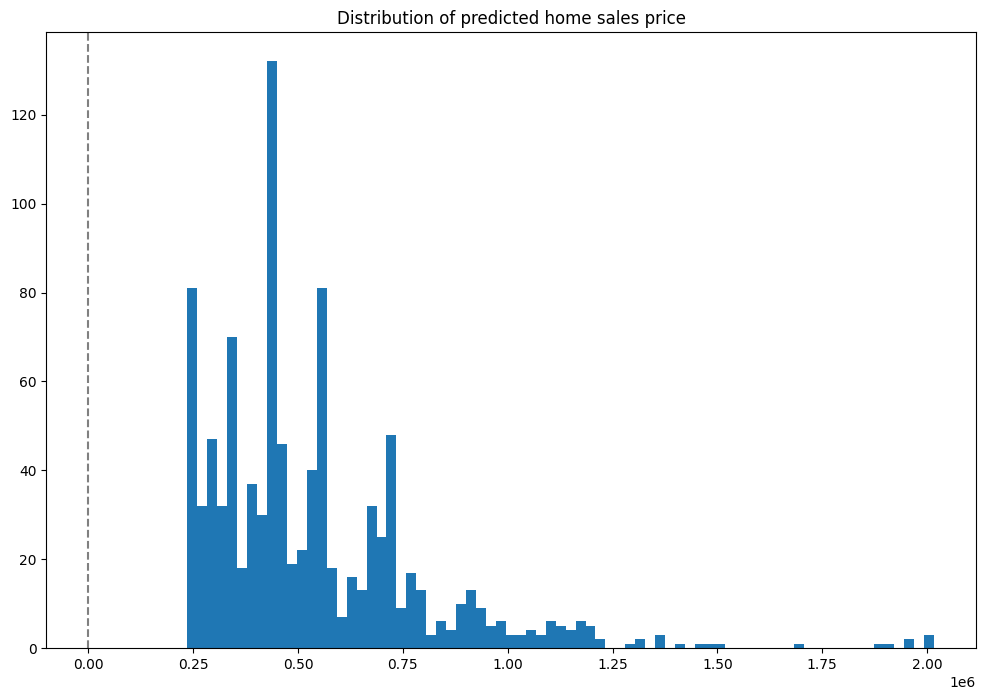

In [138]:
import matplotlib.pyplot as plt
houseprices = pd.DataFrame({'sell_price': large_inference_result['out.variable'].apply(lambda x: x[0])})

houseprices.hist(column='sell_price', bins=75, grid=False, figsize=(12,8))
plt.axvline(x=40, color='gray', ls='--')
_ = plt.title('Distribution of predicted home sales price')

# Used for the logging example
control_model_end = datetime.datetime.now()

### Pipeline Logs

Pipeline logs with standard pipeline steps are retrieved either with:

* Pipeline `logs` which returns either a pandas DataFrame or Apache Arrow table.
* Pipeline `export_logs` which saves the logs either a pandas DataFrame JSON file or Apache Arrow table.

For full details, see the Wallaroo Documentation Pipeline Log Management guide.

#### Pipeline Log Methods

The Pipeline `logs` method accepts the following parameters.

| `limit` | **Int** (*Optional*) | Limits how many log records to display.  Defaults to `100`.  If there are more pipeline logs than are being displayed, the **Warning** message `Pipeline log record limit exceeded` will be displayed.  For example, if 100 log files were requested and there are a total of 1,000, the warning message will be displayed. |
| `start` and `end` | **DateTime** (*Optional*) | Limits logs to all logs between the `start` and `end` DateTime parameters.  **Both parameters must be provided**. Submitting a `logs()` request with only `start` or `end` will generate an exception.<br />If `start` and `end` are provided as parameters, then the records are returned in **chronological** order, with the oldest record displayed first. |
| `arrow` | **Boolean** (*Optional*) | Defaults to **False**.  If `arrow` is set to `True`, then the logs are returned as an [Apache Arrow table](https://arrow.apache.org/).  If `arrow=False`, then the logs are returned as a pandas DataFrame. |

The following examples demonstrate displaying the logs, then displaying the logs between the `control_model_start` and `control_model_end` periods, then again retrieved as an Arrow table.

In [ ]:
# pipeline log retrieval - reverse chronological order

display(mainpipeline.logs())

# pipeline log retrieval between two dates - chronological order

display(mainpipeline.logs(start=control_model_start, end=control_model_end))

# pipeline log retrieval limited to the last 5 an an arrow table

display(mainpipeline.logs(limit=5, arrow=True))

## Assays

Create a baseline

Display assay results over the last whatever

get some charts



## Shadow Deploy

Let's assume that after analyzing the assay information we want to test two challenger models to our control.  We do that with the Shadow Deploy pipeline step.

In Shadow Deploy, the pipeline step is added with the `add_shadow_deploy` method, with the champion model listed first, then an array of challenger models after.  **All** inference data is fed to **all** models, with the champion results displayed in the `out.variable` column, and the shadow results in the format `out_{model name}.variable`.  For example, since we named our challenger models `housingchallenger01` and `housingchallenger02`, the columns `out_housingchallenger01.variable` and `out_housingchallenger02.variable` have the shadow deployed model results.

For this example, we will remove the previous pipeline step, then replace it with a shadow deploy step with `rf_model.onnx` as our champion, and models `xgb_model.onnx` and `gbr_model.onnx` as the challengers.  We'll deploy the pipeline and prepare it for sample inferences.

In [139]:
# Upload the challenger models

model_name_challenger01 = 'housingchallenger01'
model_file_name_challenger01 = './models/xgb_model.onnx'

model_name_challenger02 = 'housingchallenger02'
model_file_name_challenger02 = './models/gbr_model.onnx'

housing_model_challenger01 = wl.upload_model(model_name_challenger01, model_file_name_challenger01).configure()
housing_model_challenger02 = wl.upload_model(model_name_challenger02, model_file_name_challenger02).configure()


In [140]:
# Undeploy the pipeline
mainpipeline.undeploy()

# Add the new shadow deploy step with our challenger models
mainpipeline.replace_with_shadow_deploy(0, housing_model_control, [housing_model_challenger01, housing_model_challenger02])

# Deploy the pipeline with the new shadow step
mainpipeline.deploy()

name,housepricepipeline
created,2023-04-04 18:12:27.091404+00:00
last_updated,2023-04-05 21:12:15.857075+00:00
deployed,True
tags,
versions,"767c8404-a36f-4fd1-a34f-593af9b87996, ad4585d6-2bc7-4d29-a11e-8ef47bee370e, c1d92d4e-c4ca-4c11-a802-43b8e6867808, 1ea11068-7bae-4400-92b4-51a31290c91b, 8264a2bb-ce9d-4d8e-a4b7-537d94aed528, 402e478a-e22c-4188-9ba1-409b5d0d4cc1, 38d38c84-8168-4d21-b297-cbd302d7adbc, 8b02be2f-7c45-4987-a4ac-ffd1c9cdd1a8, 8d99eb2d-83c6-4a62-b951-41fdfae065c0, 02caeaac-460c-4dff-830f-8f47b4d8ca17, a286219e-2cf2-4aaa-852e-ad177477349c, 62c7588b-cf06-4037-9d99-1e925deacd9c, 4d4ba08c-7398-4ba5-a2b8-29ff2055390b, c4dea78e-2b3c-4056-8b34-ddc0c7d8a716, a8097a1d-cff1-4de3-82cf-f5c3bb469858, f094d5b4-e6ea-4e0a-aa3f-2f4a1f385eb9, 0413ebb2-96cd-4a6e-a8ea-3fa9cc387834, 9d810ca8-35c8-4b3c-9496-7e277fc87fa3"
steps,housingcontrol


### Shadow Deploy Sample Inference

We'll now use our same sample data for an inference to our shadow deployed pipeline, then display the first 20 results with just the comparative outputs.

In [141]:
shadow_result = mainpipeline.infer_from_file('./data/xtest-1k.arrow')

shadow_outputs =  shadow_result.to_pandas()
display(shadow_outputs.loc[0:20,['out.variable','out_housingchallenger01.variable','out_housingchallenger02.variable']])

,out.variable,out_housingchallenger01.variable,out_housingchallenger02.variable
0,[718013.75],[659806.0],[704901.9]
1,[615094.56],[732883.5],[695994.44]
2,[448627.72],[419508.84],[416164.8]
3,[758714.2],[634028.8],[655277.2]
4,[513264.7],[427209.44],[426854.66]
5,[668288.0],[615501.9],[632556.1]
6,[1004846.5],[1139732.5],[1100465.2]
7,[684577.2],[498328.88],[528278.06]
8,[727898.1],[722664.4],[659439.94]
9,[559631.1],[525746.44],[534331.44]


## Model Swap

Now that we've completed our testing, we can swap our deployed model in the original `housepricingpipeline` with one we feel works better.  For shadow deploy pipeline steps, this will mean removing all of the pipeline steps, then adding a new pipeline step with the `gbr_model.onnx` model.

Once done, we'll perform a new inference to display results with the new model.  Note that previously, the inference through the original model returned `[718013.7]`.

In [146]:
mainpipeline.undeploy()

# remove the steps
mainpipeline.remove_step(2)
mainpipeline.remove_step(1)
mainpipeline.remove_step(0)

mainpipeline.add_model_step(housing_model_challenger02).deploy()


name,housepricepipeline
created,2023-04-04 18:12:27.091404+00:00
last_updated,2023-04-05 21:17:21.405574+00:00
deployed,True
tags,
versions,"ee4655bc-0950-4fe2-8fda-d488f29d9ec1, 6a8a0298-4a66-43ea-b9be-8fb53cfba0a4, 767c8404-a36f-4fd1-a34f-593af9b87996, ad4585d6-2bc7-4d29-a11e-8ef47bee370e, c1d92d4e-c4ca-4c11-a802-43b8e6867808, 1ea11068-7bae-4400-92b4-51a31290c91b, 8264a2bb-ce9d-4d8e-a4b7-537d94aed528, 402e478a-e22c-4188-9ba1-409b5d0d4cc1, 38d38c84-8168-4d21-b297-cbd302d7adbc, 8b02be2f-7c45-4987-a4ac-ffd1c9cdd1a8, 8d99eb2d-83c6-4a62-b951-41fdfae065c0, 02caeaac-460c-4dff-830f-8f47b4d8ca17, a286219e-2cf2-4aaa-852e-ad177477349c, 62c7588b-cf06-4037-9d99-1e925deacd9c, 4d4ba08c-7398-4ba5-a2b8-29ff2055390b, c4dea78e-2b3c-4056-8b34-ddc0c7d8a716, a8097a1d-cff1-4de3-82cf-f5c3bb469858, f094d5b4-e6ea-4e0a-aa3f-2f4a1f385eb9, 0413ebb2-96cd-4a6e-a8ea-3fa9cc387834, 9d810ca8-35c8-4b3c-9496-7e277fc87fa3"
steps,housingcontrol


In [147]:
# inference after model swap

normal_input = pd.DataFrame.from_records({"tensor": [[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]]})
result = mainpipeline.infer(normal_input)
display(result)

,time,in.tensor,out.variable,check_failures
0,2023-04-05 21:17:38.381,"[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]",[704901.9],0


### Undeploy Main Pipeline

With the examples and tutorial complete, we will undeploy the main pipeline and return the resources back to the Wallaroo instance.

In [148]:
mainpipeline.undeploy()

name,housepricepipeline
created,2023-04-04 18:12:27.091404+00:00
last_updated,2023-04-05 21:17:21.405574+00:00
deployed,False
tags,
versions,"ee4655bc-0950-4fe2-8fda-d488f29d9ec1, 6a8a0298-4a66-43ea-b9be-8fb53cfba0a4, 767c8404-a36f-4fd1-a34f-593af9b87996, ad4585d6-2bc7-4d29-a11e-8ef47bee370e, c1d92d4e-c4ca-4c11-a802-43b8e6867808, 1ea11068-7bae-4400-92b4-51a31290c91b, 8264a2bb-ce9d-4d8e-a4b7-537d94aed528, 402e478a-e22c-4188-9ba1-409b5d0d4cc1, 38d38c84-8168-4d21-b297-cbd302d7adbc, 8b02be2f-7c45-4987-a4ac-ffd1c9cdd1a8, 8d99eb2d-83c6-4a62-b951-41fdfae065c0, 02caeaac-460c-4dff-830f-8f47b4d8ca17, a286219e-2cf2-4aaa-852e-ad177477349c, 62c7588b-cf06-4037-9d99-1e925deacd9c, 4d4ba08c-7398-4ba5-a2b8-29ff2055390b, c4dea78e-2b3c-4056-8b34-ddc0c7d8a716, a8097a1d-cff1-4de3-82cf-f5c3bb469858, f094d5b4-e6ea-4e0a-aa3f-2f4a1f385eb9, 0413ebb2-96cd-4a6e-a8ea-3fa9cc387834, 9d810ca8-35c8-4b3c-9496-7e277fc87fa3"
steps,housingcontrol
